In [ ]:
import numpy as np
with open("R24.txt", "r") as f:
  d, n, m, k, p = [int(x) for x in f.readline().split()]
  ks = [int(x) for x in f.readline().split()]
  data = [[float(x) for x in string.split()] for string in f.readlines()]
  data = np.array(data)

data.shape

(442037, 5)

In [ ]:
outlier = np.array([])
# outlier = outliers
# removed_outlier_data = np.delete(data, outlier, axis=0)
removed_outlier_data = data

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_embedded = pca.fit_transform(removed_outlier_data)


In [ ]:
from sklearn.cluster import KMeans
import numpy as np

clustering = KMeans(n_clusters=m, random_state=0).fit(removed_outlier_data)


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
clustering = GaussianMixture(n_components=m, random_state=0).fit(removed_outlier_data)

In [ ]:
import matplotlib.pyplot as plt

# plt.scatter(X_embedded[:,0], X_embedded[:,1]);

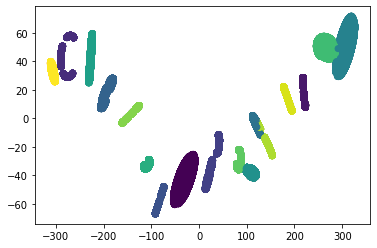

In [ ]:
# plt.scatter(pca_embedded[:,0], pca_embedded[:,1], c = clustering.labels_);
plt.scatter(pca_embedded[:,0], pca_embedded[:,1], c = clustering.predict(removed_outlier_data));

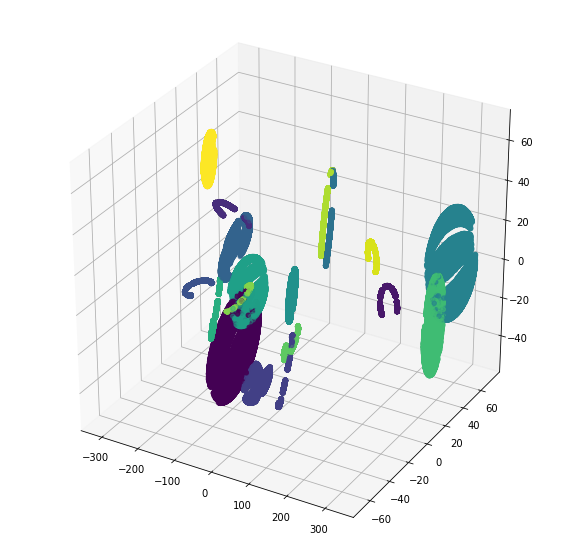

In [ ]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_embedded[:, 0], pca_embedded[:, 1], pca_embedded[:, 2], c = clustering.predict(removed_outlier_data))

plt.show()

In [ ]:
labels = []
for i in range(m):
  labels.append(removed_outlier_data[clustering.labels_ == i])

In [ ]:
def to_str_c(data):
  ans = ""
  for i in range(len(data)):
    ans += str(data[i]) + " "
  return ans

In [ ]:
def calculate_orth(label, dim=3):
  pca = PCA(n_components=d)
  pca_emb = pca.fit_transform(label)
  return pca.components_[dim:]

In [ ]:
def check_unique(col, val):
  ans = np.unique(col)
  return len(ans) == val

def find_dimension(label):
  for i in range(d + 1):
    A = label @ calculate_orth(label, i).T
    if i == 3:
      print(np.unique(A))
    if np.all(check_unique(A, d - i)):
      return i
    
find_dimension(labels[7])

[-1.51280665 -1.51190292 -1.50967216 ...  0.80026999  0.80162843
  0.80379764]


5

In [ ]:
clusters_with_outlier = clustering.labels_
# clusters_num = [3, 6, 5, 4, 4, 5, 5, 6]
ne = [20] * m
def get_sphere_data(label, c, cnum=1):
  
  di = find_dimension(label)
  ans = f'{di} {cnum} Sphere\n'
  
  PJ = calculate_orth(label, di)
  for jj in range(len(PJ)):
    ans += f'{to_str_c(PJ[jj])}\n'
  
  for jj in range(len(PJ)):
    ans += f'{(np.mean(label, axis=0) @ PJ.T)[jj]} '
  ans += f'\n'
  
  # radius, center = sphere_fit(label, 1)
  radius, center = radii[c], centers[c]
  ans += f'{to_str_c(center)} {np.round(radius, 2)}\n'
  
  indices = np.array(np.where(clusters_with_outlier == c)) + 1

  # clustering_t = SpectralClustering(n_clusters=cnum, n_neighbors = ne[c], affinity = 'nearest_neighbors', 
  #   assign_labels='kmeans',
  #   random_state=0).fit(label)

  clustering_t = KMeans(n_clusters=cnum, random_state=0).fit((label))

  for jj in range(cnum):
    temp = indices[0][clustering_t.labels_ == jj] 
    ans += f'{len(temp)} {(to_str_c(temp))}\n'

  
  # ans += f'{len(indices[0])} {(to_str_c(indices[0]))}\n'
  return ans


In [ ]:
def sphere_fit(point_cloud, lam):
    """
    input
        point_cloud: xyz of the point clouds　numpy array
    output
        radius : radius of the sphere
        sphere_center : xyz of the sphere center
    """

    A_1 = np.zeros((d,d))
    #A_1 : 1st item of A
    v_1 = np.array([0.0] * d)
    v_2 = 0.0
    v_3 = np.array([0.0] * d)
    # mean of multiplier of point vector of the point_clouds
    # v_1, v_3 : vector, v_2 : scalar

    N = len(point_cloud)
    #N : number of the points

    """Calculation of the sum(sigma)"""
    for v in point_cloud:
        v_1 += v
        v_2 += np.dot(v, v)
        v_3 += np.dot(v, v) * v

        A_1 += np.dot(np.array([v]).T, np.array([v]))

    v_1 /= N
    v_2 /= N
    v_3 /= N
    A = 2 * (A_1 / N - np.dot(np.array([v_1]).T, np.array([v_1]))) + np.eye(d, d) * lam / 2
    # formula ②
    b = v_3 - v_2 * v_1 + lam / 2 * v_1
    # formula ③
    # sphere_center = np.dot(np.linalg.inv(A), b)
    sphere_center = np.linalg.lstsq(A, b)[0]
    #　formula ①
    radius = (sum(np.linalg.norm(np.array(point_cloud) - sphere_center, axis=1))
              /len(point_cloud))

    return(radius, sphere_center)

In [ ]:
centers = []
radii = []
for i in range(m):
  radius, center = sphere_fit(labels[i], 2)
  centers.append(center)
  radii.append(radius)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [ ]:
center

array([ 598.37204951,   79.07964248, -120.80960334,   75.55782114,
         76.39654888])

In [ ]:
remained = list(range(m))
clusters_num = [-1] * m


for kk in ks:
  best_metric = 1e20
  best_manifold = -1
  for rem in remained:
    clustering_new = KMeans(n_clusters=kk, random_state=0).fit((labels[rem] - centers[rem]) / (0.1 * radii[rem]))
    if clustering_new.inertia_ / len(labels[rem]) < best_metric:
      best_manifold = rem

  clusters_num[best_manifold] = kk
  remained.remove(best_manifold)



In [ ]:
isSphere = [True] * 20
ans = f'{n} {m}\n'
for i in range(m):
  if isSphere[i]:
    ans += get_sphere_data(labels[i], i, clusters_num[i])
  print(f"{i}th manifold has been handled!")
ans += f'{len(outlier)} {to_str_c(outlier + 1)}'

0th manifold has been handled!
1th manifold has been handled!
2th manifold has been handled!
3th manifold has been handled!
4th manifold has been handled!
5th manifold has been handled!
6th manifold has been handled!
7th manifold has been handled!
8th manifold has been handled!
9th manifold has been handled!
10th manifold has been handled!
11th manifold has been handled!
12th manifold has been handled!
13th manifold has been handled!
14th manifold has been handled!
15th manifold has been handled!
16th manifold has been handled!


In [ ]:
with open("output.txt", "w") as f:
  f.write(ans)

In [ ]:
clusters_num

[5, 3, 6, 3, 6, 6, 6, 5, 3, 6, 4, 3, 3, 6, 5, 4, 6]

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
pca_ = PCA(n_components=3)
pca_embedded_ = pca_.fit_transform(labels[3])


In [ ]:
clustering_t = KMeans(n_clusters=clusters_num[3], random_state=0).fit((labels[3]))

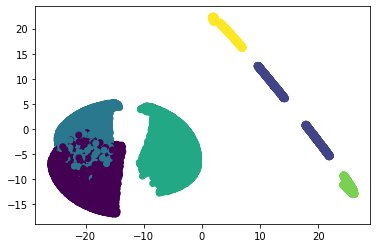

In [ ]:
plt.scatter(pca_embedded_[:,0], pca_embedded_[:,1], c=clustering_t.labels_);


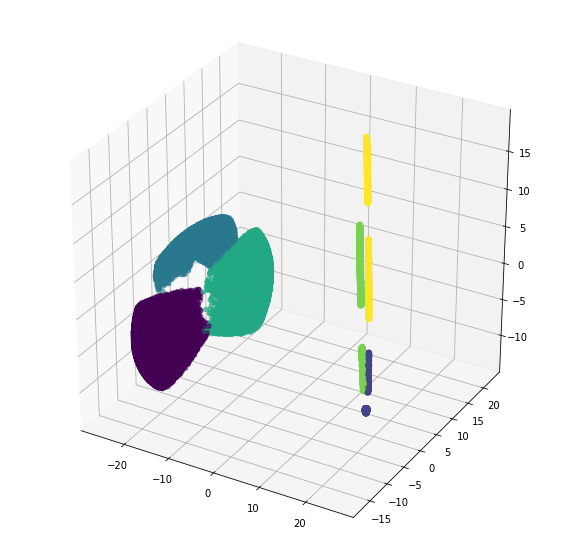

In [ ]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_embedded_[:, 0], pca_embedded_[:, 1], pca_embedded_[:, 2], c=clustering_t.labels_)

plt.show()

In [ ]:
ks

[6, 4, 5, 6, 3, 3, 4, 6, 3, 5, 6, 6, 6, 3, 6, 3, 5]

In [ ]:
clusters_num = [5, 5, 3, 6, 6, 3, 3, 6, 3, 6, 6, 4, 4, 6, 3, 6, 5]

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
def view(label):
    pca = PCA(n_components=d)
    pca_emb = pca.fit_transform(label)
    print(d)
    plt.plot(np.arange(1, d + 1), pca.explained_variance_)
    print(pca.explained_variance_)
    plt.show()

5
[4.49130953e-01 3.07275891e-01 2.43575956e-01 8.67774952e-06
 8.52283296e-06]


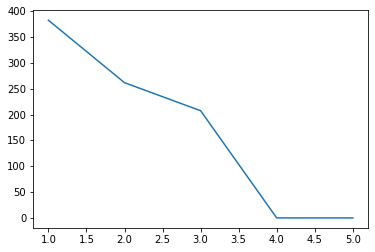

[-166.3644962  -166.36269382 -166.35396525 ...  -12.11006955  -12.1083928
  -12.10526069]


5

In [ ]:
view(labels[0])
find_dimension(labels[0])

In [ ]:
def find_dimension(label):
  for i in range(d + 1):
    pca = PCA(n_components=d)
    pca_emb = pca.fit_transform(label)
    TH = 0.001
    return len(pca.explained_variance_ratio_[pca.explained_variance_ratio_ > TH])

In [ ]:
find_dimension(labels[3])

5

5
[298.41917725 127.84382297  59.33159407  19.86022662   0.30195855]


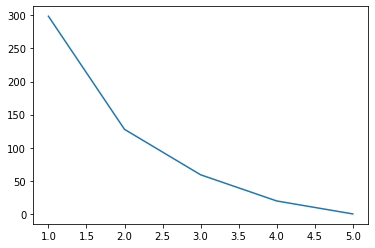

In [ ]:
view(labels[3])